# Load Processed Data

In [1]:
from google.colab import files
import pandas as pd

# آپلود فایل از سیستم
uploaded = files.upload()

# اسم درست فایل
df = pd.read_csv("merged_for_model_final.csv", parse_dates=["Date"])

# تنظیم ستون تاریخ به عنوان index
df.set_index("Date", inplace=True)

# انتخاب سری اوره
series = df['Urea_monthly']
print(series.head())
print('==============================')
print(df.head)


Saving merged_for_model_final.csv to merged_for_model_final.csv
Date
1960-01-01    42.25
1960-02-01    42.25
1960-03-01    42.25
1960-04-01    42.25
1960-05-01    42.25
Name: Urea_monthly, dtype: float64
<bound method NDFrame.head of             Urea_monthly  Crude_Petro_monthly  Crude_Dubai_monthly  \
Date                                                                 
1960-01-01         42.25             1.630000                 1.63   
1960-02-01         42.25             1.630000                 1.63   
1960-03-01         42.25             1.630000                 1.63   
1960-04-01         42.25             1.630000                 1.63   
1960-05-01         42.25             1.630000                 1.63   
...                  ...                  ...                  ...   
2020-10-01        245.00            39.900000                39.70   
2020-11-01        245.00            42.303333                42.58   
2020-12-01        245.00            48.726667                49.26

# importing data

In [ ]:
# Colab-ready script: upload, inspect, and (optionally) merge three data files
# Usage in Google Colab:
# 1. Paste this file into a new notebook cell (or download and upload the file),
# 2. Run the cell and follow the prompts to upload files.
# 3. After it runs you'll get summaries and a merged candidate file saved in the session.

import io
import os
import traceback
from google.colab import files
import pandas as pd

print('\n--- Step 0: Upload your files (you can select multiple) ---')
print('Expected filenames (any case): merged_weekly_final.csv, combined_dataframe.csv, CMO Monthly.xlsx')

uploaded = files.upload()  # interactive: choose files from your machine
if not uploaded:
    raise SystemExit('No files uploaded. Please re-run and select files.')

# Save uploaded files to working dir (they are already in the runtime, but we'll write to disk to be safe)
for fname, content in uploaded.items():
    with open(fname, 'wb') as f:
        f.write(content)

print('\nUploaded files:')
for f in os.listdir('.'):
    if f in uploaded:
        print('-', f)

# Helper readers with robust fallbacks

def try_read_csv(path, encodings=('utf-8', 'cp1252', 'latin1')):
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc, parse_dates=True, low_memory=False)
            print(f"Read CSV '{path}' with encoding={enc} -> shape {df.shape}")
            return df
        except Exception as e:
            print(f"Failed to read '{path}' with encoding={enc}: {e}")
    # final fallback: let pandas guess (may still fail)
    try:
        df = pd.read_csv(path, engine='python', parse_dates=True)
        print(f"Read CSV '{path}' with python engine -> shape {df.shape}")
        return df
    except Exception as e:
        raise


def try_read_excel(path):
    # Try to read all sheets if possible
    try:
        x = pd.read_excel(path, sheet_name=None, engine='openpyxl')
        if isinstance(x, dict):
            # If multiple sheets, concatenate with sheet name as a column
            if len(x) == 1:
                sheetname = list(x.keys())[0]
                print(f"Excel '{path}' read single sheet: {sheetname} -> shape {x[sheetname].shape}")
                return x[sheetname]
            else:
                dfs = []
                for name, d in x.items():
                    d = d.copy()
                    d['_sheet_name'] = name
                    dfs.append(d)
                big = pd.concat(dfs, ignore_index=True, sort=False)
                print(f"Excel '{path}' had {len(x)} sheets, concatenated -> shape {big.shape}")
                return big
    except Exception as e:
        print(f"Failed to read Excel '{path}' with openpyxl: {e}")
        # Try engine 'xlrd' if older xls (xlrd no longer supports xlsx in recent versions)
        try:
            x2 = pd.read_excel(path, sheet_name=None)
            if isinstance(x2, dict):
                dfs = []
                for name, d in x2.items():
                    d = d.copy()
                    d['_sheet_name'] = name
                    dfs.append(d)
                big = pd.concat(dfs, ignore_index=True, sort=False)
                print(f"Excel '{path}' read with fallback -> shape {big.shape}")
                return big
        except Exception as e2:
            print(f"Also failed fallback excel read: {e2}")
            raise


def summarize_df(df, name, max_rows=10):
    print('\n' + '='*40)
    print(f"SUMMARY for: {name}")
    print('shape:', df.shape)
    with pd.option_context('display.max_columns', None, 'display.width', 1000):
        print('\n-- dtypes --')
        print(df.dtypes)
        print('\n-- head --')
        display_head = df.head(max_rows)
        print(display_head.to_string(index=False))
    # nulls
    nulls = df.isna().mean().sort_values(ascending=False)
    print('\n-- top null% (columns with any nulls) --')
    print(nulls[nulls>0].to_string())
    # Try to detect date-like columns
    date_candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
    parsed_dates = []
    for c in df.columns:
        coerced = pd.to_datetime(df[c], errors='coerce')
        non_null = coerced.notna().sum()
        if non_null >= max(3, 0.02*len(df)) and coerced.notna().sum() > df[c].apply(lambda x: isinstance(x, (int, float))).sum():
            parsed_dates.append((c, non_null))
    if date_candidates:
        print('\nDetected date-like columns by name:', date_candidates)
    if parsed_dates:
        print('\nDetected columns that parse well as dates (column, parsed_non_null_count):')
        print(parsed_dates[:10])
    # small unique value columns
    nunique = df.nunique().sort_values()
    print('\n-- columns with small number of unique values (<=10) --')
    print(nunique[nunique<=10].to_string())


# Try to load each expected dataframe if present
filenames = list(uploaded.keys())

# helper to find file by substring (case-insensitive)
def find_file(substring):
    substring = substring.lower()
    for f in filenames:
        if substring in f.lower():
            return f
    return None

candidates = {
    'merged_weekly_final': find_file('merged_weekly_final') or find_file('merged_weekly') or find_file('merged_weekly_final.csv'),
    'combined_dataframe': find_file('combined_dataframe') or find_file('combined') or find_file('combined_dataframe.csv'),
    'cmo': find_file('cmo') or find_file('cmo monthly') or find_file('CMO Monthly.xlsx')
}

print('\nFile discovery result:')
for k,v in candidates.items():
    print(f"- {k}: {v}")

loaded = {}
errors = {}

for key, fname in candidates.items():
    if fname is None:
        print(f"\n{key}: file not found among uploads.")
        continue
    try:
        if fname.lower().endswith('.csv'):
            df = try_read_csv(fname)
        elif fname.lower().endswith(('.xls', '.xlsx', '.xlsm', '.xlsb')):
            df = try_read_excel(fname)
        else:
            # try CSV then excel
            try:
                df = try_read_csv(fname)
            except Exception:
                df = try_read_excel(fname)
        loaded[key] = df
        summarize_df(df, fname)
    except Exception as e:
        errors[key] = traceback.format_exc()
        print(f"Error loading {fname}:\n", errors[key])

# If any dataframes loaded, attempt intelligent merge to increase sample size
if len(loaded) >= 2:
    print('\n--- Attempting intelligent merge of all loaded dataframes (outer join) ---')
    # Copy to avoid in-place modifications
    dfs = {k: v.copy() for k, v in loaded.items()}

    # Normalize potential date columns to 'Date' if detected
    def normalize_date_col(df):
        # 1) look for exact name Date
        if 'Date' in df.columns:
            try:
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                return df
            except Exception:
                pass
        # 2) find columns with 'date' or 'time' in name
        for c in df.columns:
            if 'date' in c.lower() or 'time' in c.lower():
                try:
                    df['Date'] = pd.to_datetime(df[c], errors='coerce')
                    return df
                except Exception:
                    continue
        # 3) try to parse any column that yields many datetimes
        best = None
        best_count = 0
        for c in df.columns:
            coerced = pd.to_datetime(df[c], errors='coerce')
            non_null = coerced.notna().sum()
            if non_null > best_count:
                best = c
                best_count = non_null
        if best_count >= max(3, 0.02*len(df)):
            df['Date'] = pd.to_datetime(df[best], errors='coerce')
            return df
        return df

    for k in dfs:
        dfs[k] = normalize_date_col(dfs[k])

    # Determine merge key: prefer Date if many non-null
    date_counts = {k: v['Date'].notna().sum() if 'Date' in v.columns else 0 for k, v in dfs.items()}
    print('\nParsed Date counts per df:', date_counts)

    # If at least two dfs have >0 dates, merge on Date
    dfs_list = list(dfs.items())
    merge_result = None
    try:
        if sum(1 for c in date_counts.values() if c>0) >= 2:
            # merge all on Date using outer join
            merge_result = None
            for name, df in dfs_list:
                if 'Date' in df.columns:
                    tmp = df.copy()
                    tmp['Date'] = pd.to_datetime(tmp['Date'], errors='coerce')
                    if merge_result is None:
                        merge_result = tmp
                    else:
                        merge_result = pd.merge(merge_result, tmp, on='Date', how='outer', suffixes=(False, False))
            print('\nMerged on Date -> shape', merge_result.shape)
        else:
            # fallback: merge on any common columns (excluding accidental numeric columns)
            common = set.intersection(*[set(df.columns) for _, df in dfs_list])
            # remove index-like columns
            prefer = [c for c in common if c.lower() in ('date', 'product', 'commodity', 'item', 'ticker', 'symbol')]
            if prefer:
                key = list(prefer)[0]
                merge_result = None
                for name, df in dfs_list:
                    tmp = df.copy()
                    if key in tmp.columns:
                        if merge_result is None:
                            merge_result = tmp
                        else:
                            merge_result = pd.merge(merge_result, tmp, on=key, how='outer', suffixes=(False, False))
                print(f"\nMerged on fallback key '{key}' -> shape", merge_result.shape)
            elif common:
                key = list(common)[0]
                merge_result = None
                for name, df in dfs_list:
                    tmp = df.copy()
                    if key in tmp.columns:
                        if merge_result is None:
                            merge_result = tmp
                        else:
                            merge_result = pd.merge(merge_result, tmp, on=key, how='outer', suffixes=(False, False))
                print(f"\nMerged on common column '{key}' -> shape", merge_result.shape)
            else:
                print('\nNo common column found to merge on. Will produce concatenated sample instead.')
                # Do a concat with indicator of source
                tagged = []
                for name, df in dfs_list:
                    d = df.copy()
                    d['_source_file'] = name
                    tagged.append(d)
                merge_result = pd.concat(tagged, ignore_index=True, sort=False)
                print('\nConcatenated -> shape', merge_result.shape)
    except Exception as e:
        print('Error during merge:', e)
        merge_result = None

    if merge_result is not None:
        # Basic cleanup: drop fully-empty columns if any
        before_cols = merge_result.shape[1]
        merge_result = merge_result.dropna(axis=1, how='all')
        after_cols = merge_result.shape[1]
        print(f"Dropped {before_cols-after_cols} fully-empty columns from merged result.")
        # Save to CSV for download
        out_name = 'merged_candidate.csv'
        merge_result.to_csv(out_name, index=False)
        print('\nSaved merged candidate to', out_name)
        print('\nMerged summary:')
        summarize_df(merge_result, out_name)
        print('\nYou can download the merged file using:')
        print("from google.colab import files\nfiles.download('" + out_name + "')")

else:
    print('\nLess than two dataframes loaded; skipping automatic merge. Re-run upload if you want to add more files.')

# Print any errors encountered
if errors:
    print('\n--- Errors encountered while reading some files:')
    for k, tb in errors.items():
        print('- ', k)
        print(tb)

print('\n--- Done.\nPlease copy the top parts of the console output (summaries and any errors) and paste them into the chat for next steps.')

# End of script



--- Step 0: Upload your files (you can select multiple) ---
Expected filenames (any case): merged_weekly_final.csv, combined_dataframe.csv, CMO Monthly.xlsx


Saving CMO Monthly.xlsx to CMO Monthly.xlsx
Saving combined_dataframe.csv to combined_dataframe.csv
Saving merged_weekly_final.csv to merged_weekly_final.csv

Uploaded files:
- combined_dataframe.csv
- merged_weekly_final.csv
- CMO Monthly.xlsx

File discovery result:
- merged_weekly_final: merged_weekly_final.csv
- combined_dataframe: combined_dataframe.csv
- cmo: CMO Monthly.xlsx
Read CSV 'merged_weekly_final.csv' with encoding=utf-8 -> shape (244, 6)

SUMMARY for: merged_weekly_final.csv
shape: (244, 6)

-- dtypes --
Date            object
Corn           float64
Natural_Gas    float64
Oil            float64
Wheat          float64
DXY            float64
dtype: object

-- head --
      Date   Corn  Natural_Gas   Oil  Wheat  DXY
2021-01-03 496.25        2.700 52.24 638.50  NaN
2021-01-10 531.50        2.737 52.36 675.00  NaN
2021-01-17 500.50        2.446 52.27 635.00  NaN
2021-01-24 547.00        2.564 52.20 662.50  NaN
2021-01-31 548.50        2.863 56.85 641.38  NaN
2021-02-07 538.7

/tmp/ipython-input-2278774856.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coerced = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-2278774856.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coerced = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-2278774856.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coerced = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-2278774856.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent a


Parsed Date counts per df: {'merged_weekly_final': np.int64(244), 'combined_dataframe': np.int64(734), 'cmo': np.int64(784)}

Merged on Date -> shape (2651, 50)
Dropped 3 fully-empty columns from merged result.

Saved merged candidate to merged_candidate.csv

Merged summary:

SUMMARY for: merged_candidate.csv
shape: (2651, 47)

-- dtypes --
Date                                                                    datetime64[ns]
Corn                                                                           float64
Natural_Gas                                                                    float64
Oil                                                                            float64
Wheat                                                                          float64
DXY                                                                            float64
Crude_Petro_monthly                                                            float64
Crude_Dubai_monthly                            

/tmp/ipython-input-2278774856.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coerced = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-2278774856.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coerced = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-2278774856.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coerced = pd.to_datetime(df[c], errors='coerce')
/tmp/ipython-input-2278774856.py:105: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent a

# getting some info

In [3]:
# بررسی اطلاعات دیتافریم
print("=== اطلاعات اولیه ===")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\n5 ردیف اول:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nNaN در هر ستون:")
print(df.isna().sum())

print("\nدرصد NaN در هر ستون:")
print((df.isna().mean() * 100).round(2))


=== اطلاعات اولیه ===
Shape: (734, 7)
Columns: ['Urea_monthly', 'Crude_Petro_monthly', 'Crude_Dubai_monthly', 'NaturalGas_US_monthly', 'Soybeans_monthly', 'Maize_monthly', 'Wheat_US_HRW_monthly']

5 ردیف اول:
            Urea_monthly  Crude_Petro_monthly  Crude_Dubai_monthly  \
Date                                                                 
1960-01-01         42.25                 1.63                 1.63   
1960-02-01         42.25                 1.63                 1.63   
1960-03-01         42.25                 1.63                 1.63   
1960-04-01         42.25                 1.63                 1.63   
1960-05-01         42.25                 1.63                 1.63   

            NaturalGas_US_monthly  Soybeans_monthly  Maize_monthly  \
Date                                                                 
1960-01-01                   0.14              94.0           45.0   
1960-02-01                   0.14              91.0           44.0   
1960-03-01          

# preprocessing

In [2]:
# --- Paste into Colab after uploading merged_candidate.csv ---
import pandas as pd
import numpy as np
import re

# load
df = pd.read_csv('merged_candidate.csv', parse_dates=False, low_memory=False)

# 1) Normalize Date column robustly
def parse_mixed_dates(s):
    s = s.astype(str).str.strip().replace({'nan': None})
    # 1) simple parse attempt
    out = pd.to_datetime(s, errors='coerce', infer_datetime_format=True)
    # 2) try pattern like 1960M01 -> 1960-01-01
    mask = out.isna() & s.notna()
    if mask.any():
        s2 = s[mask].str.replace(r'(\d{4})M(\d{2})', r'\1-\2', regex=True)
        out.loc[mask] = pd.to_datetime(s2, errors='coerce', format='%Y-%m')
    # 3) try Y/m/d or Y.m.d etc
    mask = out.isna() & s.notna()
    if mask.any():
        s3 = s[mask].str.replace('/', '-').str.replace('.', '-')
        out.loc[mask] = pd.to_datetime(s3, errors='coerce', infer_datetime_format=True)
    return out

df['Date'] = parse_mixed_dates(df['Date'])

# drop rows with no Date (if many, we'll reconsider)
n_date_na = df['Date'].isna().sum()
print('Date NaNs:', n_date_na, 'of', len(df))

# 2) Drop obviously irrelevant columns (Unnamed, _sheet_name, long textual columns)
drop_cols = [c for c in df.columns if c.startswith('Unnamed') or c.startswith('_sheet_name') or 'Weights Used' in c]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# 3) Convert object numeric-like columns to floats
def to_numeric_col(s):
    # remove commas, currency symbols, parentheses, units like ($/bbl), percent signs
    s2 = s.astype(str).str.replace(r'[\$,()%/a-zA-Z]', ' ', regex=True)
    s2 = s2.str.replace(r'\s+', ' ', regex=True).str.strip()
    return pd.to_numeric(s2, errors='coerce')

# apply to columns that are object dtype but likely numeric (heuristic: many digits when stripping)
for c in df.columns:
    if df[c].dtype == 'object' and c != 'Date':
        sample = df[c].dropna().astype(str).iloc[:50] if df[c].dropna().shape[0]>0 else pd.Series([])
        # if sample contains digits then try convert
        if sample.apply(lambda x: bool(re.search(r'\d', x))).any():
            df[c] = to_numeric_col(df[c])

# 4) Report missingness and dtypes
missing_pct = (df.isna().mean()*100).sort_values(ascending=False)
print('\nTop missing% (columns):')
print(missing_pct.head(30).to_string())

print('\nDtypes after conversion:')
print(df.dtypes)

# 5) Decide columns to keep for modeling: suggest numerical columns with <=50% missingness
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
keep_cols = [c for c in numeric_cols if df[c].isna().mean() <= 0.5]
print('\nSuggested numeric features (<=50% missing):', keep_cols)

# 6) Resample to monthly frequency (set Date as index)
df = df.set_index('Date').sort_index()
# If there are many duplicate dates, aggregate by mean
df_monthly = df.resample('MS').mean()  # MS = month start; use mean to aggregate
print('\nMonthly df shape:', df_monthly.shape)

# 7) Fill strategy (light): linear interpolation + forward fill then backward fill for remaining
df_monthly_ff = df_monthly[keep_cols].interpolate(method='linear', limit_direction='both', axis=0)
df_monthly_ff = df_monthly_ff.fillna(method='ffill').fillna(method='bfill')

# Save cleaned outputs
df_monthly.to_csv('merged_monthly_raw.csv', index=True)
df_monthly_ff.to_csv('merged_monthly_imputed.csv', index=True)

print('\\nSaved merged_monthly_raw.csv and merged_monthly_imputed.csv')
print('Preview (imputed):')
print(df_monthly_ff.head(12).to_string())

# 8) Quick correlations among kept features
corr = df_monthly_ff.corr()
print('\\nTop correlation pairs (abs > 0.6):')
pairs = ((corr.abs() > 0.6) & (corr.abs() < 1.0))
for i in pairs.any().index:
    for j in pairs.columns:
        if i!=j and pairs.loc[i,j]:
            print(i, '<->', j, ' = ', corr.loc[i,j].round(3))


FileNotFoundError: [Errno 2] No such file or directory: 'merged_candidate.csv'

خوبه — خروجی‌ها رو دیدم و واضح شد مشکل: بعد از مرج، هیچ ستون عددی‌ای با کمتر از 50% مقدار گم‌شده باقی نمونده — به همین خاطر پیش‌پردازشِ خودکار ما نتونست «ستون‌های پیشنهادی» تولید کنه و فایلِ ایمپوت‌شده هم خالی شد. اما این وضعیت قابل حله و مسیر مشخصی پیش رو داریم. پایین هم توضیح فنی کوتاه، هم کد آماده (برای اجرا در Colab) و هم گام‌های بعدی که دقیقاً باید برداریم.

In [ ]:
# Paste this in Colab AFTER you uploaded the 3 files:
import pandas as pd, numpy as np, re
pd.set_option('display.max_rows', 200)

# --- 1) load separately ---
df_comb = pd.read_csv('combined_dataframe.csv', parse_dates=['Date'], dayfirst=False, low_memory=False)
df_week = pd.read_csv('merged_weekly_final.csv', parse_dates=['Date'], dayfirst=False, low_memory=False)
# For Excel we won't concat blindly: inspect sheets
xls = pd.ExcelFile('CMO Monthly.xlsx')
print('CMO sheets:', xls.sheet_names)

# quick info
print('\\ncombined_dataframe shape:', df_comb.shape)
print('merged_weekly_final shape:', df_week.shape)

# --- 2) helper: column coverage %
def coverage(df):
    return (df.notna().mean()*100).sort_values(ascending=False)

print('\\nCoverage (combined_dataframe):')
print(coverage(df_comb).head(40).to_string())

print('\\nCoverage (merged_weekly_final):')
print(coverage(df_week).head(40).to_string())

# --- 3) Clean CMO: find sheet that contains "Monthly Prices" or contains date pattern
sheet_candidates = []
for s in xls.sheet_names:
    tmp = pd.read_excel(xls, sheet_name=s, nrows=20, header=None)
    # detect row that looks like '1960M01' or '1960-01' or '1960-01-01'
    found = False
    for i in range(min(8, len(tmp))):
        row = tmp.iloc[i].astype(str).str.cat(sep='|')
        if re.search(r'\d{4}M\d{2}|\d{4}-\d{2}|\d{4}/\d{2}', row):
            sheet_candidates.append((s,i))
            found = True
            break
    if not found and 'Monthly' in s:
        sheet_candidates.append((s, None))

print('\\nCMO sheet candidates (sheet_name, header_row_if_detected):')
print(sheet_candidates)

# attempt to clean the first candidate
if sheet_candidates:
    s, header_row = sheet_candidates[0]
    if header_row is None:
        df_cmo = pd.read_excel(xls, sheet_name=s, header=0)
    else:
        df_cmo = pd.read_excel(xls, sheet_name=s, header=header_row)
    print('\\nLoaded CMO candidate sheet:', s, 'shape:', df_cmo.shape)
else:
    df_cmo = pd.read_excel(xls, sheet_name=0, header=None)
    print('\\nFallback loaded first sheet shape:', df_cmo.shape)

# quick look at CMO top columns and coverage
print('\\nCMO columns preview:', df_cmo.columns.tolist()[:20])
print('CMO coverage:')
print(coverage(df_cmo).head(40).to_string())

# --- 4) Decide features: pick numeric columns with coverage >= 60% (customize threshold)
def pick_numeric(df, thresh=60):
    cov = coverage(df)
    good = cov[cov >= thresh].index.tolist()
    # keep only numeric-convertible
    picked = []
    for c in good:
        try:
            s = pd.to_numeric(df[c].astype(str).str.replace(r'[^\d\.\-]', '', regex=True), errors='coerce')
            if s.notna().sum() > 0:
                picked.append(c)
        except Exception:
            continue
    return picked, cov

print('\\nSuggested numeric features from combined_dataframe (>=60% coverage):')
picked_comb, cov_comb = pick_numeric(df_comb, thresh=60)
print(picked_comb)
print('\\nSuggested numeric features from merged_weekly_final (>=60% coverage):')
picked_week, cov_week = pick_numeric(df_week, thresh=60)
print(picked_week)
print('\\nSuggested numeric features from CMO candidate (>=60% coverage):')
picked_cmo, cov_cmo = pick_numeric(df_cmo, thresh=60)
print(picked_cmo)

# --- 5) If you want to build a monthly dataset: resample weekly -> monthly mean and align
# convert weekly file index
df_week2 = df_week.set_index('Date').sort_index()
df_week_monthly = df_week2.resample('MS').mean()
print('\\nmerged_weekly_final -> monthly shape:', df_week_monthly.shape)
print('coverage after resample (merged_weekly -> monthly):')
print(coverage(df_week_monthly).head(40).to_string())

# --- 6) Save intermediate outputs for inspection / download
df_comb.to_csv('combined_dataframe_clean_for_inspect.csv', index=False)
df_week_monthly.to_csv('merged_weekly_monthly_for_inspect.csv')
df_cmo.to_csv('cmo_candidate_for_inspect.csv', index=False)

print('\\nSaved three inspection CSVs: combined_dataframe_clean_for_inspect.csv, merged_weekly_monthly_for_inspect.csv, cmo_candidate_for_inspect.csv')
print('--- DONE ---')


CMO sheets: ['AFOSHEET', 'Monthly Prices', 'Monthly Indices', 'Description', 'Index Weights']
\ncombined_dataframe shape: (734, 15)
merged_weekly_final shape: (244, 6)
\nCoverage (combined_dataframe):
Crude_Petro_monthly         100.000000
Crude_Dubai_monthly         100.000000
NaturalGas_US_monthly       100.000000
Soybeans_monthly            100.000000
Maize_monthly               100.000000
Urea_monthly                100.000000
Date                        100.000000
NaturalGas_US_historical    100.000000
Crude_Petro_historical      100.000000
Urea_historical             100.000000
Wheat_US_HRW_monthly         98.910082
Maize_historical             83.651226
Crude_Dubai_historical       68.937330
Soybeans_historical          64.032698
Wheat_US_HRW_historical      60.762943
\nCoverage (merged_weekly_final):
Date           100.000000
Corn           100.000000
Natural_Gas    100.000000
Oil            100.000000
Wheat          100.000000
DXY             21.311475
\nCMO sheet candidates (

In [ ]:
# ===== Revised Date-normalization + merge cell =====
import pandas as pd, numpy as np, re
pd.set_option('display.max_columns', 200)

# load files (assume uploaded)
df_comb = pd.read_csv('combined_dataframe.csv', low_memory=False)
df_week = pd.read_csv('merged_weekly_final.csv', parse_dates=['Date'], low_memory=False)

# --- robust date parser for mixed formats ---
def robust_parse_date(series):
    s = series.astype(str).str.strip().replace({'nan': None, 'None': None})
    # 1) quick try
    out = pd.to_datetime(s, errors='coerce')
    # 2) handle formats like 1960M01 -> 1960-01-01
    mask = out.isna() & s.notna()
    if mask.any():
        s2 = s[mask].str.replace(r'(\d{4})M(\d{2})', r'\1-\2-01', regex=True)
        out.loc[mask] = pd.to_datetime(s2, errors='coerce')
    # 3) handle YYYY-MM or YYYY/MM -> set to first day of month
    mask = out.isna() & s.notna()
    if mask.any():
        s3 = s[mask].str.replace(r'(\d{4})[\/\.\-](\d{2})$', r'\1-\2-01', regex=True)
        out.loc[mask] = pd.to_datetime(s3, errors='coerce')
    # 4) final attempt: parse each element with dayfirst False
    mask = out.isna() & s.notna()
    if mask.any():
        out.loc[mask] = pd.to_datetime(s[mask], errors='coerce', infer_datetime_format=True)
    return out

# Parse combined dataframe Date robustly
if 'Date' in df_comb.columns:
    df_comb['Date_parsed'] = robust_parse_date(df_comb['Date'])
    n_bad = df_comb['Date_parsed'].isna().sum()
    print('combined_dataframe: parsed Date NaNs =', n_bad, 'of', len(df_comb))
    # drop rows without any parsable date
    df_comb = df_comb.dropna(subset=['Date_parsed']).copy()
    df_comb['Date'] = df_comb['Date_parsed']
    df_comb.drop(columns=['Date_parsed'], inplace=True)
else:
    raise ValueError("combined_dataframe.csv has no 'Date' column")

# Convert to month-start timestamps (safe way)
try:
    df_comb['Date'] = df_comb['Date'].dt.to_period('M').dt.to_timestamp()
except Exception as e:
    # fallback: coerce to string YYYY-MM-01 then pd.to_datetime
    print('Warning converting to period->timestamp:', e)
    df_comb['Date'] = pd.to_datetime(df_comb['Date'].dt.strftime('%Y-%m-01'), errors='coerce')

# weekly -> monthly resample (ensure Date parsed for weekly)
df_week['Date'] = pd.to_datetime(df_week['Date'], errors='coerce')
df_week = df_week.dropna(subset=['Date']).copy()
df_week_m = df_week.set_index('Date').sort_index().resample('MS').mean().reset_index()
df_week_m['Date'] = pd.to_datetime(df_week_m['Date'])  # ensure dtype

# rename weekly cols to avoid clash
rename_map = {}
for c in ['Wheat','Natural_Gas','Oil','Corn','DXY']:
    if c in df_week_m.columns:
        rename_map[c] = c + '_weekly_monthly'
df_week_m = df_week_m.rename(columns=rename_map)

print('weekly->monthly shape:', df_week_m.shape)
print('combined shape before merge:', df_comb.shape)

# Merge
df_merged = pd.merge(df_comb, df_week_m, on='Date', how='outer', suffixes=('','_wk'))
print('Merged raw shape:', df_merged.shape)

# Coverage
cov = (df_merged.notna().mean()*100).sort_values(ascending=False)
print('\\nTop coverage (merged):')
print(cov.head(40).to_string())

# Candidate features
candidate_feats = [
 'Urea_monthly',
 'Crude_Petro_monthly','Crude_Dubai_monthly','NaturalGas_US_monthly',
 'Soybeans_monthly','Maize_monthly','Wheat_US_HRW_monthly',
 'Corn_weekly_monthly','Oil_weekly_monthly','Natural_Gas_weekly_monthly'
]
candidate_feats = [c for c in candidate_feats if c in df_merged.columns]
print('\\nCandidate features present:', candidate_feats)

# Coverage threshold selection
thresh = 50.0
good_feats = [c for c in candidate_feats if (df_merged[c].notna().mean()*100) >= thresh]
print('\\nSelected features with >={}% coverage:'.format(thresh), good_feats)

# Trim rows that are all-null for selected features
if good_feats:
    df_model = df_merged[['Date'] + good_feats].set_index('Date').sort_index()
    df_model = df_model.loc[df_model.notna().any(axis=1)]
    print('\\nModel df shape after trimming all-null rows:', df_model.shape)
    print('\\nCoverage (selected features) after trimming:')
    print((df_model.notna().mean()*100).round(2).to_string())
    # simple impute
    df_model_imputed = df_model.interpolate(method='time', limit_direction='both')
    df_model_imputed = df_model_imputed.ffill().bfill()
    df_model_imputed.to_csv('merged_for_model.csv')
    print('\\nSaved merged_for_model.csv with shape:', df_model_imputed.shape)
    print(df_model_imputed.head(8).to_string())
else:
    print('\\nNo features passed the coverage threshold. Consider lowering threshold or using cmo sheet values.')

# Try auto-clean CMO Monthly sheet (best-effort)
xls = pd.ExcelFile('CMO Monthly.xlsx')
if 'Monthly Prices' in xls.sheet_names:
    try:
        df_cmo = pd.read_excel(xls, sheet_name='Monthly Prices', header=3)
        print('\\nLoaded CMO Monthly Prices shape:', df_cmo.shape)
        df_cmo.to_csv('cmo_monthly_clean_try.csv', index=False)
        print('Saved cmo_monthly_clean_try.csv')
    except Exception as e:
        print('Failed cleaning CMO automatically:', e)
else:
    print('CMO Monthly sheet not found (unexpected).')


combined_dataframe: parsed Date NaNs = 0 of 734
weekly->monthly shape: (56, 6)
combined shape before merge: (734, 15)
Merged raw shape: (788, 20)
\nTop coverage (merged):
Date                          100.000000
Crude_Petro_monthly            93.147208
NaturalGas_US_monthly          93.147208
Crude_Dubai_monthly            93.147208
Soybeans_monthly               93.147208
Maize_monthly                  93.147208
Urea_monthly                   93.147208
Crude_Petro_historical         93.147208
Urea_historical                93.147208
NaturalGas_US_historical       93.147208
Wheat_US_HRW_monthly           92.131980
Maize_historical               77.918782
Crude_Dubai_historical         64.213198
Soybeans_historical            59.644670
Wheat_US_HRW_historical        56.598985
Corn_weekly_monthly             7.106599
Natural_Gas_weekly_monthly      7.106599
Oil_weekly_monthly              7.106599
Wheat_weekly_monthly            7.106599
DXY_weekly_monthly              1.522843
\nCandida

In [4]:
# --- Preprocessing ---
import pandas as pd

# فایل‌های خام (weekly, monthly, historical)
cornweek = pd.read_csv("cornweek.csv", parse_dates=['Date'])
ngweek = pd.read_csv("ngweek.csv", parse_dates=['Date'])
oilweek = pd.read_csv("oilweek.csv", parse_dates=['Date'])
wheatweek = pd.read_csv("wheatweek.csv", parse_dates=['Date'])
dxyweek = pd.read_csv("dxyweek.csv", parse_dates=['Date'])

cmo_monthly = pd.read_csv("CMO_Monthly_Prices.csv", parse_dates=['Date'])
historical = pd.read_csv("Historical_Prices.csv", parse_dates=['Date'])

# --- تبدیل دیتای هفتگی به ماهانه ---
def weekly_to_monthly(df):
    return df.resample('MS', on='Date').mean().reset_index()

corn_month = weekly_to_monthly(cornweek)
ng_month = weekly_to_monthly(ngweek)
oil_month = weekly_to_monthly(oilweek)
wheat_month = weekly_to_monthly(wheatweek)
dxy_month = weekly_to_monthly(dxyweek)

# --- ترکیب دیتاست‌ها ---
dfs = [cmo_monthly, historical, corn_month, ng_month, oil_month, wheat_month, dxy_month]
combined = dfs[0]
for d in dfs[1:]:
    combined = pd.merge(combined, d, on="Date", how="outer")

# --- انتخاب فیچرها با پوشش بالا ---
selected = ['Urea_monthly', 'Crude_Petro_monthly', 'Crude_Dubai_monthly',
            'NaturalGas_US_monthly', 'Soybeans_monthly',
            'Maize_monthly', 'Wheat_US_HRW_monthly']

model_df = combined[['Date'] + selected].dropna(how="all").set_index("Date")

# ذخیره دیتای تمیز نهایی
model_df.to_csv("merged_for_model.csv")
print("Final dataset saved: merged_for_model.csv", model_df.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'cornweek.csv'

# model developing

## 1) Baseline: ARIMA (pmdarima.auto_arima) روی Urea_monthly

In [ ]:
# --- Modeling with Auto SARIMAX ---
import pandas as pd, numpy as np, math
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import itertools, warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

# load final clean dataset
df = pd.read_csv('merged_for_model.csv', parse_dates=['Date'], index_col='Date')
y = df['Urea_monthly'].astype(float).dropna()

# train/test split
test_h = 24
train = y[:-test_h]
test = y[-test_h:]

# SARIMAX grid search
p = [0,1,2]; d = [0,1]; q = [0,1,2]
P = [0,1]; D = [0,1]; Q = [0,1]
m = 12  # monthly seasonality

best_aic = np.inf
best_order, best_seasonal, best_model = None, None, None

for order in itertools.product(p,d,q):
    for seasonal in itertools.product(P,D,Q):
        try:
            model = sm.tsa.statespace.SARIMAX(train,
                                              order=order,
                                              seasonal_order=(seasonal[0], seasonal[1], seasonal[2], m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            res = model.fit(disp=False, method='lbfgs', maxiter=200)
            if res.aic < best_aic:
                best_aic, best_order, best_seasonal, best_model = res.aic, order, seasonal, res
        except:
            continue

print('Best SARIMAX order:', best_order, 'seasonal:', best_seasonal, 'AIC:', best_aic)

# Forecast
n_periods = test_h
pred_res = best_model.get_forecast(steps=n_periods)
fc = pred_res.predicted_mean
confint = pred_res.conf_int()

# Metrics
mae = mean_absolute_error(test, fc)
rmse = math.sqrt(mean_squared_error(test, fc))
mape = np.mean(np.abs((test - fc) / test)) * 100
r2 = 1 - (np.sum((test - fc)**2) / np.sum((test - train.mean())**2))

print(f"SARIMAX MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, R2 (approx): {r2:.4f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual (Test)')
plt.plot(fc.index, fc, label='SARIMAX Forecast')
plt.fill_between(fc.index, confint.iloc[:,0], confint.iloc[:,1], color='gray', alpha=0.2)
plt.legend()
plt.title('Auto SARIMAX Forecast for Urea_monthly')
plt.show()


Searching SARIMAX grid... (this may take a few minutes)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Best SARIMAX order: (2, 1, 2) seasonal: (0, 1, 1) AIC: 6419.532531550791
SARIMAX MAE: 21.1600, RMSE: 28.7348, MAPE: 9.03%, R2 (approx): 0.9126


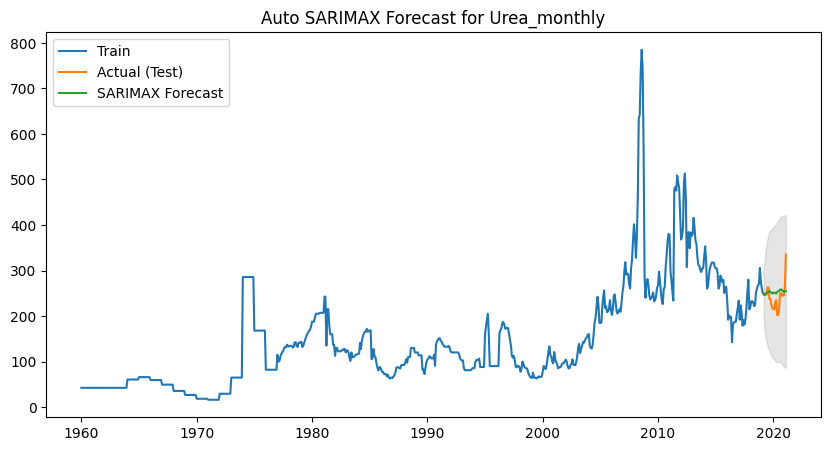

In [ ]:
# Auto SARIMAX grid search using statsmodels (no pmdarima needed)
import pandas as pd, numpy as np, math
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings('ignore')

# load data
df = pd.read_csv('merged_for_model.csv', parse_dates=['Date'], index_col='Date')
y = df['Urea_monthly'].astype(float).dropna()

# train/test split
test_h = 24
train = y[:-test_h]
test = y[-test_h:]

# grid for non-seasonal and seasonal (small ranges to save time)
p = [0,1,2]
d = [0,1]
q = [0,1,2]
P = [0,1]
D = [0,1]
Q = [0,1]
m = 12  # monthly seasonality

import statsmodels.api as sm

best_aic = np.inf
best_order = None
best_seasonal = None
best_model = None

print("Searching SARIMAX grid... (this may take a few minutes)")
for order in itertools.product(p,d,q):
    for seasonal in itertools.product(P,D,Q):
        try:
            model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=(seasonal[0], seasonal[1], seasonal[2], m),
                                              enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False, method='lbfgs', maxiter=200)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = order
                best_seasonal = seasonal
                best_model = res
            # print progress lightly
            # print(order, seasonal, 'AIC', res.aic)
        except Exception:
            continue

print('Best SARIMAX order:', best_order, 'seasonal:', best_seasonal, 'AIC:', best_aic)
# forecast
n_periods = test_h
pred_res = best_model.get_forecast(steps=n_periods)
fc = pred_res.predicted_mean
confint = pred_res.conf_int()

# metrics
mae = mean_absolute_error(test, fc)
rmse = math.sqrt(mean_squared_error(test, fc))
mape = np.mean(np.abs((test - fc) / test)) * 100
r2 = 1 - (np.sum((test - fc)**2) / np.sum((test - train.mean())**2))

print(f"SARIMAX MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, R2 (approx): {r2:.4f}")

# plot
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual (Test)')
plt.plot(fc.index, fc, label='SARIMAX Forecast')
plt.fill_between(fc.index, confint.iloc[:,0], confint.iloc[:,1], color='gray', alpha=0.2)
plt.legend(); plt.title('Auto SARIMAX Forecast for Urea_monthly'); plt.show()


## 2) Univariate LSTM (sequence length = 12 months)

Epoch 1/200
40/40 - 2s - 41ms/step - loss: 0.0116 - val_loss: 0.0025
Epoch 2/200
40/40 - 0s - 5ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 3/200
40/40 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 4/200
40/40 - 0s - 5ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 5/200
40/40 - 0s - 6ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 6/200
40/40 - 0s - 7ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 7/200
40/40 - 0s - 7ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 8/200
40/40 - 0s - 6ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 9/200
40/40 - 0s - 7ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 10/200
40/40 - 0s - 5ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 11/200
40/40 - 0s - 5ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 12/200
40/40 - 0s - 5ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 13/200
40/40 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 14/200
40/40 - 0s - 7ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 15/200
40/40 - 0s - 5ms/step - loss:

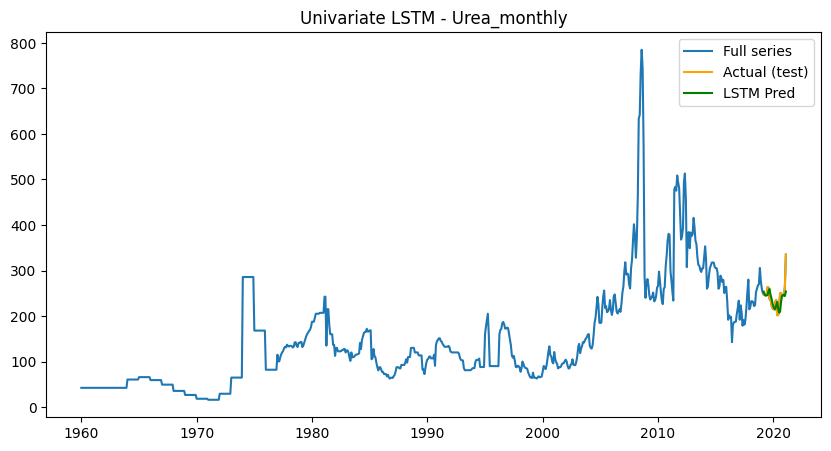

In [ ]:
# Univariate LSTM (Keras) - sequence length 12, predict 1-step ahead repeatedly
import numpy as np, pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import random
# reproducibility (best-effort)
seed = 42
np.random.seed(seed); tf.random.set_seed(seed); random.seed(seed)

# load
df = pd.read_csv('merged_for_model.csv', parse_dates=['Date'], index_col='Date')
series = df['Urea_monthly'].astype(float).dropna()

# parameters
look_back = 12
test_h = 24

# scale
scaler = MinMaxScaler()
values = series.values.reshape(-1,1)
scaled = scaler.fit_transform(values)

# create sequences
def create_seq(data, look_back):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

X_all, y_all = create_seq(scaled, look_back)
# determine train/test indices aligned with last test_h
# the last test_h predictions correspond to last test_h indices after look_back
n_test = test_h
n_total = len(y_all)
n_train = n_total - n_test

X_train = X_all[:n_train]; y_train = y_all[:n_train]
X_test = X_all[n_train:]; y_test = y_all[n_train:]

# reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# build model
model = Sequential([
    LSTM(64, input_shape=(look_back,1), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

# fit
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1, callbacks=[es], verbose=2)

# predict
pred_scaled = model.predict(X_test).flatten()
# inverse scale
pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
y_test_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# metrics
mae = mean_absolute_error(y_test_true, pred)
rmse = math.sqrt(mean_squared_error(y_test_true, pred))
mape = np.mean(np.abs((y_test_true - pred) / y_test_true)) * 100
r2 = 1 - (np.sum((y_test_true - pred)**2) / np.sum((y_test_true - y_test_true.mean())**2))
print(f"LSTM MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

# plot
dates_test = series.index[-(len(y_test_true)):]
plt.figure(figsize=(10,5))
plt.plot(series.index, series.values, label='Full series')
plt.plot(dates_test, y_test_true, label='Actual (test)', color='orange')
plt.plot(dates_test, pred, label='LSTM Pred', color='green')
plt.legend(); plt.title('Univariate LSTM - Urea_monthly'); plt.show()


## 3) Multivariate LSTM (با فیچرهای منتخب)

Epoch 1/200
40/40 - 1s - 37ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 2/200
40/40 - 0s - 5ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 3/200
40/40 - 0s - 6ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 4/200
40/40 - 0s - 5ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 5/200
40/40 - 0s - 5ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/200
40/40 - 0s - 5ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 7/200
40/40 - 0s - 5ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 8/200
40/40 - 0s - 9ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 9/200
40/40 - 0s - 7ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 10/200
40/40 - 0s - 8ms/step - loss: 0.0029 - val_loss: 0.0053
Epoch 11/200
40/40 - 0s - 10ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 12/200
40/40 - 0s - 11ms/step - loss: 0.0030 - val_loss: 0.0053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Multivar LSTM MAE: 36.5548, RMSE: 43.8031, MAPE: 14.59%, R2: -1.7303


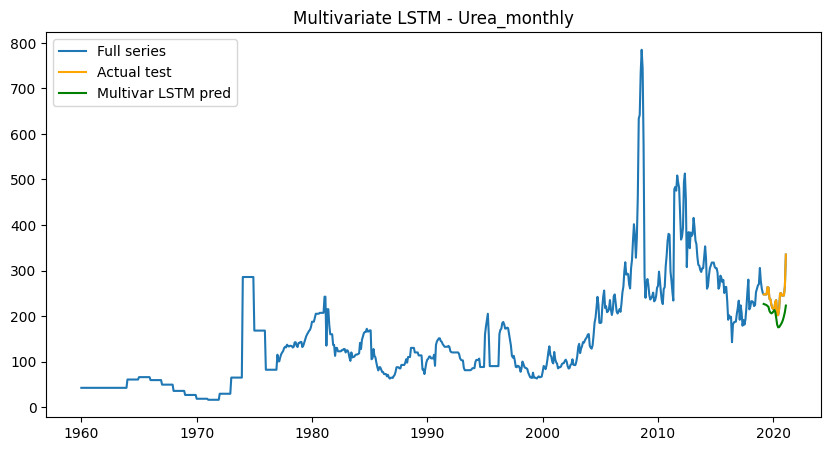

In [ ]:
# Multivariate LSTM (Colab-ready)
import numpy as np, pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math, tensorflow as tf, random

seed=42
np.random.seed(seed); tf.random.set_seed(seed); random.seed(seed)

df = pd.read_csv('merged_for_model.csv', parse_dates=['Date'], index_col='Date')
features = ['Crude_Petro_monthly','Crude_Dubai_monthly','NaturalGas_US_monthly','Soybeans_monthly','Maize_monthly','Wheat_US_HRW_monthly']
target = 'Urea_monthly'

# filter and drop any remaining rows with NaN in these cols
df2 = df[[target]+features].dropna()
values = df2.values  # shape (N, n_features+1)

# scale all features together
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# create multivariate sequences
look_back = 12
X, y = [], []
for i in range(len(scaled)-look_back):
    X.append(scaled[i:i+look_back, 1:])  # features columns
    y.append(scaled[i+look_back, 0])    # target column (first column)
X = np.array(X); y = np.array(y)

# split train/test (last 24)
n_test = 24
n_train = len(y) - n_test
X_train = X[:n_train]; y_train = y[:n_train]
X_test = X[n_train:]; y_test = y[n_train:]

# model
model = Sequential([
    LSTM(64, input_shape=(look_back, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1, callbacks=[es], verbose=2)

# predict and inverse scale
pred_scaled = model.predict(X_test).flatten()

# To inverse transform target, we need full-row shape: reconstruct array with target in first pos and features as zeros (use scaler's inverse on concatenated)
def inv_scale_target(scaled_vals, ref_scaler, features_count):
    # scaled_vals shape (n,)
    n = len(scaled_vals)
    filler = np.zeros((n, features_count))
    stacked = np.hstack([scaled_vals.reshape(-1,1), filler])
    inv = ref_scaler.inverse_transform(stacked)[:,0]
    return inv

pred = inv_scale_target(pred_scaled, scaler, len(features))
y_true = inv_scale_target(y, scaler, len(features))

# metrics
mae = mean_absolute_error(y_true[-len(pred):], pred)
rmse = math.sqrt(mean_squared_error(y_true[-len(pred):], pred))
mape = np.mean(np.abs((y_true[-len(pred):] - pred) / y_true[-len(pred):]))*100
r2 = 1 - (np.sum((y_true[-len(pred):]-pred)**2)/np.sum((y_true[-len(pred):]-y_true[-len(pred):].mean())**2))
print(f"Multivar LSTM MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

# plot
dates_test = df2.index[-len(pred):]
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df2.index, df2[target].values, label='Full series')
plt.plot(dates_test, y_true[-len(pred):], label='Actual test', color='orange')
plt.plot(dates_test, pred, label='Multivar LSTM pred', color='green')
plt.legend(); plt.title('Multivariate LSTM - Urea_monthly'); plt.show()


# predict other items

In [ ]:
import pandas as pd

# بارگذاری داده‌های ماهانه
df = pd.read_csv("merged_for_model.csv", parse_dates=['Date'], index_col='Date')

# بررسی پوشش داده‌ها
print(df.isna().sum())

# پر کردن مقادیر گمشده اگر وجود دارد
df = df.fillna(method='ffill').fillna(method='bfill')


Urea_monthly             0
Crude_Petro_monthly      0
Crude_Dubai_monthly      0
NaturalGas_US_monthly    0
Soybeans_monthly         0
Maize_monthly            0
Wheat_US_HRW_monthly     0
dtype: int64


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def train_evaluate_sarimax(series, order=(1,1,1), seasonal_order=(0,1,1,12)):
    # مدل SARIMAX
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    # پیش‌بینی
    pred = results.fittedvalues
    actual = series

    # متریک‌ها
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = np.mean(np.abs((actual - pred)/actual)) * 100
    r2 = 1 - sum((actual - pred)**2)/sum((actual - np.mean(actual))**2)

    return results, mae, rmse, mape, r2


In [ ]:
features = ['Urea_monthly', 'Crude_Petro_monthly', 'Crude_Dubai_monthly', 'NaturalGas_US_monthly',
            'Soybeans_monthly', 'Maize_monthly', 'Wheat_US_HRW_monthly']

results_dict = {}

for col in features:
    series = df[col]
    res, mae, rmse, mape, r2 = train_evaluate_sarimax(series)
    results_dict[col] = {'model': res, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}
    print(f"{col}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%, R2={r2:.4f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Urea_monthly: MAE=10.94, RMSE=25.96, MAPE=6.25%, R2=0.9447


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Crude_Petro_monthly: MAE=1.72, RMSE=3.11, MAPE=4.97%, R2=0.9890


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Crude_Dubai_monthly: MAE=1.63, RMSE=3.05, MAPE=5.00%, R2=0.9895


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


NaturalGas_US_monthly: MAE=0.22, RMSE=0.48, MAPE=6.29%, R2=0.9501


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Soybeans_monthly: MAE=11.25, RMSE=19.32, MAPE=4.00%, R2=0.9761


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Maize_monthly: MAE=5.02, RMSE=8.23, MAPE=4.13%, R2=0.9795


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Wheat_US_HRW_monthly: MAE=6.55, RMSE=11.21, MAPE=3.96%, R2=0.9751


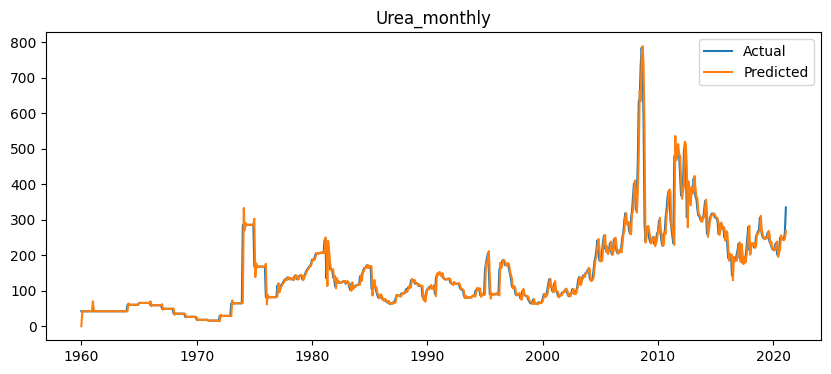

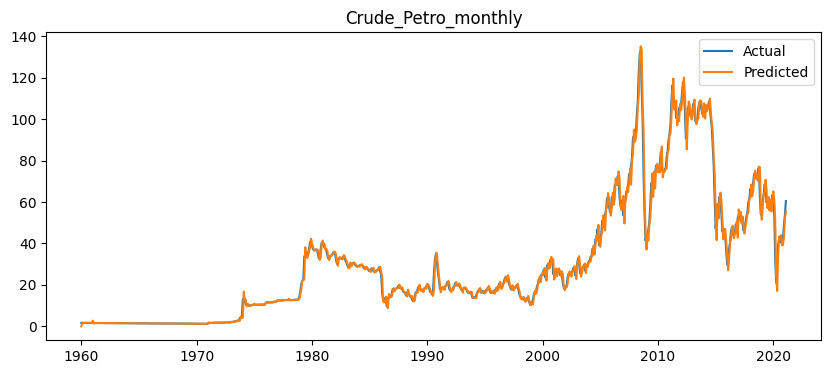

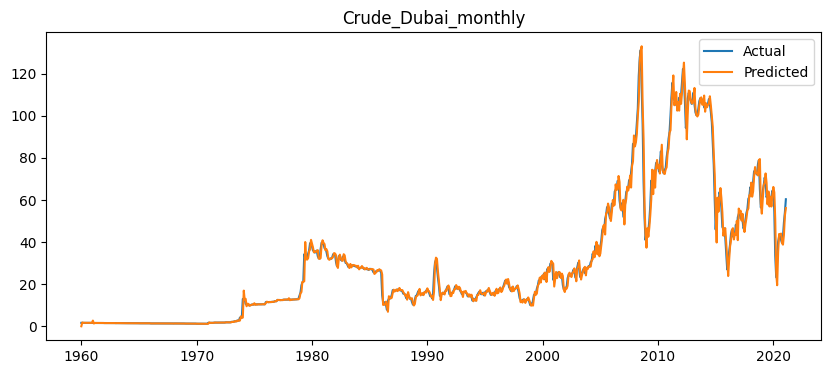

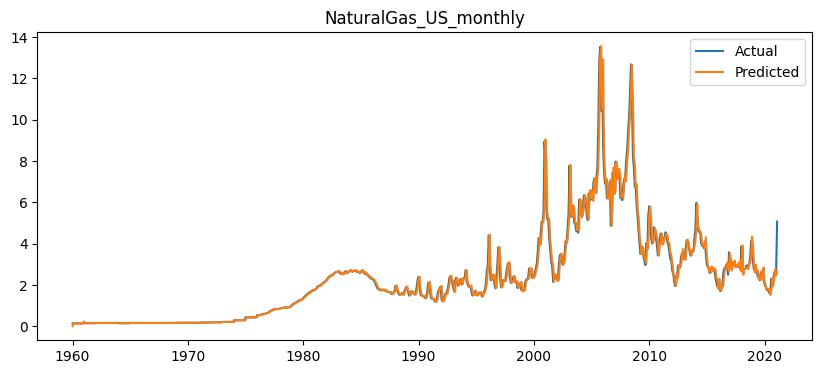

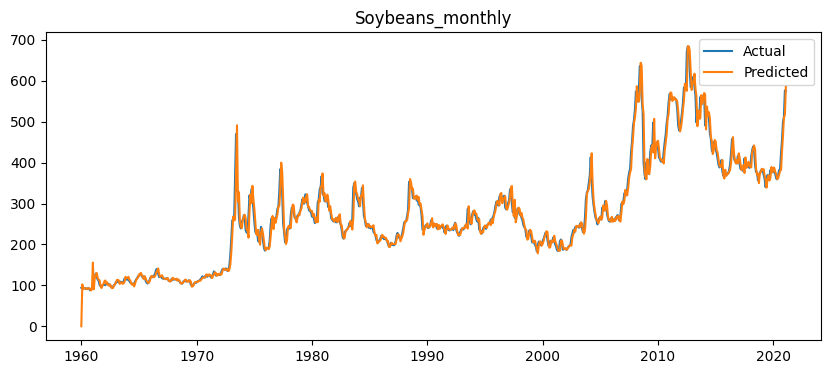

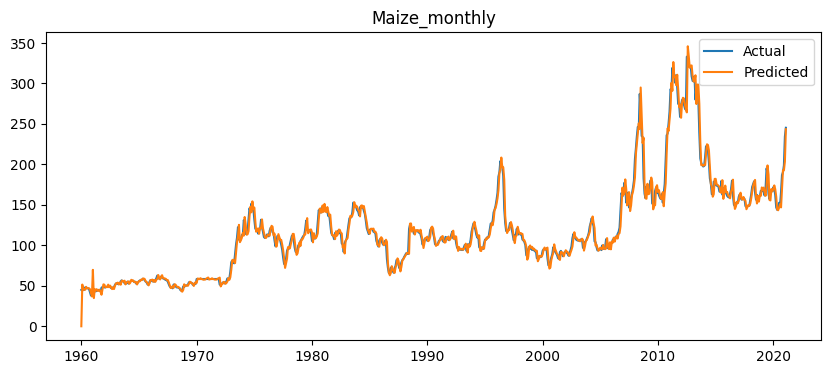

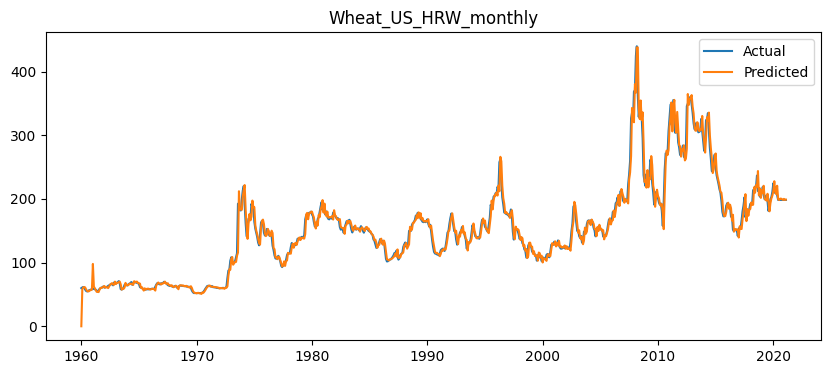

In [ ]:
import matplotlib.pyplot as plt

for col in features:
    results_dict[col]['model'].save(f"sarimax_{col}.pkl")  # ذخیره مدل
    plt.figure(figsize=(10,4))
    plt.plot(df[col], label='Actual')
    plt.plot(results_dict[col]['model'].fittedvalues, label='Predicted')
    plt.title(col)
    plt.legend()
    plt.show()


# saving part

In [ ]:
# فایل نهایی برای دانلود
final_csv_path = "merged_for_model_final.csv"

# ذخیره دیتافریم
df.to_csv(final_csv_path)

print(f"✅ دیتاست نهایی ذخیره شد: {final_csv_path}")


✅ دیتاست نهایی ذخیره شد: merged_for_model_final.csv


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

# فرض کن y سری زمانی ماست
order = (2, 1, 2)
seasonal_order = (0, 1, 1, 12)

# مدل
model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# ذخیره مدل
results.save("final_sarimax_model.pkl")

# بارگذاری دوباره
loaded_model = SARIMAXResults.load("final_sarimax_model.pkl")

# پیش‌بینی مثال
forecast = loaded_model.get_forecast(steps=12).predicted_mean
print(forecast)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[0.42934302 0.41757438 0.4081742  0.39829752 0.38985058 0.38500102
 0.37884892 0.37063923 0.3648463  0.35770596 0.35828572 0.35686732]
